In [1]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(input_shape=(150, 150, 3), include_top=False)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [2]:
import os 
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

base_dir = "/content/drive/MyDrive/cats-and-dogs"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

Two methods going forward:
  1. Run the Pretrained VGG convnet on the images save extracted features on disk and then pass it to a densely connected Neural Network.
  2. Make the pretrained ConvNet a part of the model. Requires an extra step of freezing the trainable parameters on the convnet (conv_base.trainable = False)

Since the image processing part through the VGG Convnet takes significant time, chose to do it the second way.

In [3]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
          break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000)


Found 2030 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


In [6]:
from keras import models, layers 
from tensorflow.keras import optimizers 

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              loss="binary_crossentropy", 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(
    train_features, 
    train_labels, 
    epochs=30, 
    batch_size=20, 
    validation_data = (validation_features, validation_labels)
)

Epoch 1/30
100/100 [==============================] - 3s 23ms/step - loss: 0.4611 - accuracy: 0.7780 - val_loss: 0.2749 - val_accuracy: 0.8950
Epoch 2/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2887 - accuracy: 0.8795 - val_loss: 0.3457 - val_accuracy: 0.8560
Epoch 3/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2337 - accuracy: 0.8985 - val_loss: 0.2006 - val_accuracy: 0.9280
Epoch 4/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2079 - accuracy: 0.9210 - val_loss: 0.1810 - val_accuracy: 0.9340
Epoch 5/30
100/100 [==============================] - 2s 20ms/step - loss: 0.1843 - accuracy: 0.9320 - val_loss: 0.1718 - val_accuracy: 0.9370
Epoch 6/30
100/100 [==============================] - 2s 20ms/step - loss: 0.1481 - accuracy: 0.9475 - val_loss: 0.1618 - val_accuracy: 0.9410
Epoch 7/30
100/100 [==============================] - 2s 20ms/step - loss: 0.1310 - accuracy: 0.9535 - val_loss: 0.1583 - val_accuracy: 0.9370

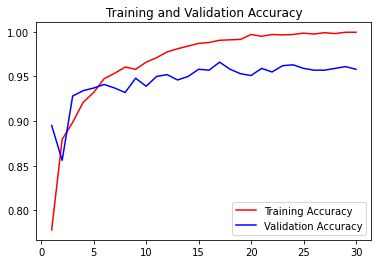

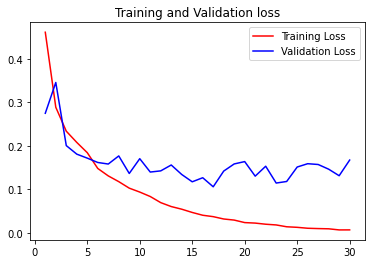

In [8]:
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = [x for x in range(1, len(acc)+1)]

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [9]:
model.evaluate(test_features, test_labels)

32/32 [==============================] - 0s 5ms/step - loss: 0.1691 - accuracy: 0.9600


[0.16907252371311188, 0.9599999785423279]